### cVAE | cGAN
- 이제까지 본 VAE 와 GAN 은 모두 이미지를 생성하기는 하지만,
- `내가 원하는 이미지` 를 생성하는 능력은 전무하다.
- 이제 조건을 줘서 `원하는 이미지` 를 줄 수 있도록 해야 하는데
- 그래서 이 것을 Conditional 을 붙여서 cVAE | cGAN 이라고 한다.

### cVAE & cGAN — ‘조건부 생성 모델’의 핵심 아이디어

 - 우리가 지금까지 본 모델들:
  - AE / VAE → “이미지를 복원/재구성하는 능력”
  - GAN → “진짜처럼 보이는 이미지를 생성하는 능력”

 - 하지만 이들은 한 가지 공통적인 한계가 있다:
   - `무엇을 만들지 제어가 안 된다.`
   - (ex: 3을 만들고 싶은데 8이 나올 수도 있음)

 - 실제 응용에서는 “특정 조건을 가진 데이터를 생성”하는 경우가 훨씬 많다:
   - 숫자 ‘3’만 만들고 싶다
   - 여자 얼굴만 만들고 싶다
   - 특정 스타일의 이미지를 만들고 싶다
   - 텍스트에 맞는 이미지를 만들고 싶다 (Stable Diffusion도 이 계열)

이 문제를 해결하기 위해 등장한 것이 조건부 생성 모델(Conditional Generative Models)
과거에는 대표적으로 cVAE와 cGAN.


이 이상의 텍스트 입력을 이해하기 위해서는 일단 텍스트 생성 모델부터 배워야 하니, 그 부분은 뒤로 넘기자.

### cVAE (Conditional VAE)
 - 기본 아이디어:
   - VAE는 원래
   - Encoder: x → z
   - Decoder: z → x̂
 - cVAE는 여기에 label(y) 를 넣어
   - Encoder: (x, y) → z
   - Decoder: (z, y) → x̂
   - 으로 확장한다.

즉,  `라벨과 함께 입력된 이미지`를, `해당 라벨 조건에 맞게` `재구성`한다.

이 구조 덕분에:

원하는 숫자/클래스를 명확하게 생성할 수 있다.

digit=3 → z샘플링 → Decoder(z, "3") → “3” 이미지

digit=8 → Decoder(z, "8") → “8” 이미지

즉, cVAE는 확률 모델 기반의 조건부 생성을 수행한다.

### GAN의 구조는
 - G: z → fake
 - D: x → real/fake
 - cGAN은 이를 다음처럼 바꾼다:

G: (z, y) → 해당 y에 해당하는 가짜 이미지 생성
D: (x, y) → 이미지 x가 y라벨에 해당하는 “진짜인지/가짜인지” 분류

 - 즉, GAN이 “진짜처럼 보이는 이미지”를 만들도록 경쟁시키는 대신,
 - cGAN은 ‘특정한 클래스 조건을 만족하는’ 진짜 같은 이미지를 만드는 경쟁을 학습하게 된다.


digit=3 넣고 생성 → 정말 “3처럼 보이는” 이미지 생성

digit=7 넣으면 → “7처럼 보이는” 이미지 생성

GAN의 sharp한 장점을 유지하면서 조건부 생성이 가능해진다!

라벨이 있으면, 생성 모델의 능력은 한 단계 더 확장된다.

그냥 숫자를 만드는 모델 → 조건을 반영해 원하는 숫자만 만드는 모델

그냥 얼굴을 생성하는 모델 → 나이/성별/스타일까지 통제되는 모델

즉, 비지도 → 조건부 지도학습으로 넘어가는 순간, 생성 모델이 실용적이 된다.

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 20
label_dim = 10

def one_hot(labels, num_classes=10):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

# cVAE Model
class Encoder(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(28*28 + label_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x, y_onehot):
        x = x.view(x.size(0), -1)
        h = torch.cat([x, y_onehot], dim=1)
        h = self.relu(self.fc1(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, 400)
        self.fc2 = nn.Linear(400, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, y_onehot):
        h = torch.cat([z, y_onehot], dim=1)
        h = self.relu(self.fc1(h))
        out = self.sigmoid(self.fc2(h))
        return out.view(-1, 1, 28, 28)


class CVAE(nn.Module):
    def __init__(self, latent_dim=20, label_dim=10):
        super().__init__()
        self.encoder = Encoder(latent_dim, label_dim)
        self.decoder = Decoder(latent_dim, label_dim)

    def forward(self, x, y_onehot):
        mu, logvar = self.encoder(x, y_onehot)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z, y_onehot)
        return x_hat, mu, logvar

In [2]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

def cvae_loss(x, x_hat, mu, logvar):
    recon = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    "./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = CVAE(latent_dim, label_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_params(model))

epochs = 50
model.train()

for epoch in range(1, epochs+1):
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_onehot = one_hot(y, label_dim).to(device)

        x_hat, mu, logvar = model(x, y_onehot)
        loss = cvae_loss(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[cVAE] Epoch {epoch}/{epochs} Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "cvae_mnist.pth")
print("Saved: cvae_mnist.pth")

Trainable parameters: 660824
[cVAE] Epoch 1/50 Loss: 20902.7285
[cVAE] Epoch 2/50 Loss: 15262.2842
[cVAE] Epoch 3/50 Loss: 14347.9297
[cVAE] Epoch 4/50 Loss: 13932.6096
[cVAE] Epoch 5/50 Loss: 13677.8705
[cVAE] Epoch 6/50 Loss: 13499.6281
[cVAE] Epoch 7/50 Loss: 13374.2533
[cVAE] Epoch 8/50 Loss: 13270.4284
[cVAE] Epoch 9/50 Loss: 13189.6524
[cVAE] Epoch 10/50 Loss: 13116.8670
[cVAE] Epoch 11/50 Loss: 13060.2706
[cVAE] Epoch 12/50 Loss: 13011.0186
[cVAE] Epoch 13/50 Loss: 12965.7484
[cVAE] Epoch 14/50 Loss: 12931.9899
[cVAE] Epoch 15/50 Loss: 12899.8706
[cVAE] Epoch 16/50 Loss: 12863.7108
[cVAE] Epoch 17/50 Loss: 12837.8284
[cVAE] Epoch 18/50 Loss: 12807.2486
[cVAE] Epoch 19/50 Loss: 12783.7958
[cVAE] Epoch 20/50 Loss: 12763.7051
[cVAE] Epoch 21/50 Loss: 12741.7699
[cVAE] Epoch 22/50 Loss: 12719.4609
[cVAE] Epoch 23/50 Loss: 12701.3242
[cVAE] Epoch 24/50 Loss: 12691.6209
[cVAE] Epoch 25/50 Loss: 12667.0329
[cVAE] Epoch 26/50 Loss: 12655.0858
[cVAE] Epoch 27/50 Loss: 12640.8064
[cVAE] E

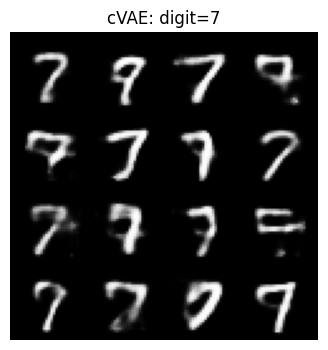

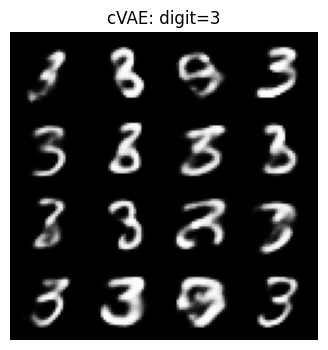

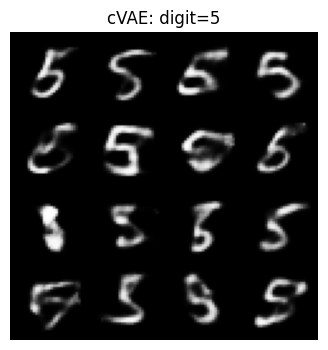

In [4]:
import matplotlib.pyplot as plt
from torchvision import utils

model = CVAE(latent_dim, label_dim).to(device)
model.load_state_dict(torch.load("cvae_mnist.pth", map_location=device))
model.eval()

def generate_cvae(digit=5, num_samples=16):
    z = torch.randn(num_samples, latent_dim, device=device)
    labels = torch.full((num_samples,), digit, dtype=torch.long, device=device)
    y_onehot = one_hot(labels, label_dim).to(device)

    with torch.no_grad():
        out = model.decoder(z, y_onehot)

    grid = utils.make_grid(out.cpu(), nrow=4)
    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1,2,0), cmap="gray")
    plt.axis("off")
    plt.title(f"cVAE: digit={digit}")
    plt.show()

# 숫자 넣으면 그 숫자를 num_samples 개수 만큼 생성 함.
generate_cvae(7)
generate_cvae(3)
generate_cvae(5)

In [5]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
label_dim = 10

def one_hot(labels, num_classes=10):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

class CondGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z, y_onehot):
        h = torch.cat([z, y_onehot], dim=1)
        out = self.net(h)
        return out.view(-1, 1, 28, 28)

class CondDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28 + label_dim, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1)
        )

    def forward(self, x, y_onehot):
        x = x.view(x.size(0), -1)
        h = torch.cat([x, y_onehot], dim=1)
        return self.net(h).view(-1)


In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

criterion = nn.BCEWithLogitsLoss()

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST("./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

# Model
G = CondGenerator().to(device)
D = CondDiscriminator().to(device)

def count_params(model):
    return sum(p.numel() for p in G.parameters() if p.requires_grad)

print("Generator Trainable parameters:", count_params(model))

def count_params(model):
    return sum(p.numel() for p in D.parameters() if p.requires_grad)

print("Discriminator Trainable parameters:", count_params(model))

opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

epochs = 50

for epoch in range(1, epochs+1):
    for real, labels in train_loader:
        real = real.to(device)
        labels = labels.to(device)
        y_onehot = one_hot(labels, label_dim).to(device)

        bsz = real.size(0)
        real_labels = torch.ones(bsz, device=device)
        fake_labels = torch.zeros(bsz, device=device)

        # Train D
        logits_real = D(real, y_onehot)
        loss_D_real = criterion(logits_real, real_labels)

        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z, y_onehot).detach()
        logits_fake = D(fake, y_onehot)
        loss_D_fake = criterion(logits_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Trian G
        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z, y_onehot)
        logits_fake2 = D(fake, y_onehot)
        loss_G = criterion(logits_fake2, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"[cGAN] Epoch {epoch}/{epochs}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

torch.save(G.state_dict(), "cgan_generator.pth")
torch.save(D.state_dict(), "cgan_discriminator.pth")
print("Saved cGAN models.")

Generator Trainable parameters: 1488912
Discriminator Trainable parameters: 538625
[cGAN] Epoch 1/50  Loss_D: 0.9569  Loss_G: 1.3074
[cGAN] Epoch 2/50  Loss_D: 1.3268  Loss_G: 2.1472
[cGAN] Epoch 3/50  Loss_D: 0.7870  Loss_G: 1.6673
[cGAN] Epoch 4/50  Loss_D: 1.1277  Loss_G: 3.6515
[cGAN] Epoch 5/50  Loss_D: 0.6282  Loss_G: 2.6594
[cGAN] Epoch 6/50  Loss_D: 0.6330  Loss_G: 2.2132
[cGAN] Epoch 7/50  Loss_D: 0.6719  Loss_G: 2.6076
[cGAN] Epoch 8/50  Loss_D: 0.8220  Loss_G: 2.1800
[cGAN] Epoch 9/50  Loss_D: 0.8037  Loss_G: 1.3583
[cGAN] Epoch 10/50  Loss_D: 1.0198  Loss_G: 1.4417
[cGAN] Epoch 11/50  Loss_D: 1.1776  Loss_G: 0.7598
[cGAN] Epoch 12/50  Loss_D: 1.0601  Loss_G: 1.0044
[cGAN] Epoch 13/50  Loss_D: 1.0890  Loss_G: 1.2415
[cGAN] Epoch 14/50  Loss_D: 1.0713  Loss_G: 1.5223
[cGAN] Epoch 15/50  Loss_D: 1.2742  Loss_G: 0.5939
[cGAN] Epoch 16/50  Loss_D: 1.1673  Loss_G: 1.2289
[cGAN] Epoch 17/50  Loss_D: 1.2062  Loss_G: 1.1791
[cGAN] Epoch 18/50  Loss_D: 1.2237  Loss_G: 1.4720
[cGAN] E

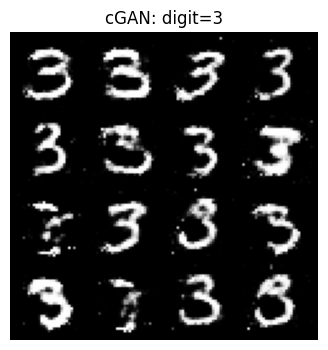

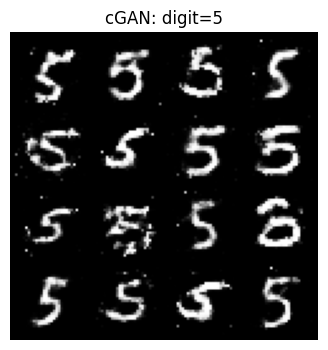

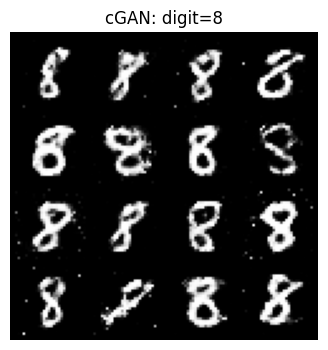

In [7]:
import matplotlib.pyplot as plt
from torchvision import utils

G = CondGenerator().to(device)
G.load_state_dict(torch.load("cgan_generator.pth", map_location=device))
G.eval()

def generate_cgan(digit=5, num_samples=16):
    z = torch.randn(num_samples, latent_dim, device=device)
    labels = torch.full((num_samples,), digit, dtype=torch.long, device=device)
    y_onehot = one_hot(labels, label_dim).to(device)

    with torch.no_grad():
        out = G(z, y_onehot).cpu()

    out = (out + 1) / 2
    grid = utils.make_grid(out, nrow=4)
    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1,2,0), cmap="gray")
    plt.axis("off")
    plt.title(f"cGAN: digit={digit}")
    plt.show()

# 숫자 넣으면 그 숫자를 num_samples 개수 만큼 생성 함.
generate_cgan(3)
generate_cgan(5)
generate_cgan(8)

위 처럼, 랜덤 결과가 아닌 원하는 숫자를 생성하게 학습 할 수 있다.

심심하면 파라미터나, 모델 구조등을 바꿔가면서 실험해서 최적의 결과를 뽑아봐도 좋다.